In [ ]:
kediler="/content/drive/MyDrive/kedikopek/Cat"

In [ ]:
import os # dosyalara ulaşmak için kullanıyoruz
import cv2 # resimleri okumak ve işlemek için gerekli
from tqdm import tqdm # okuma işlemini takip için kullanıyoruz

In [ ]:
# kediler'deki resimleri okurken boyut * boyut 
# şeklinde yeniden boyutlandıracağız, CNN için kare şeklinde olmaları avantaj
# kötü yanı: veride kareden çok farklı resimler orantısız olacak
# başta kareye benzemeyenleri elemek için ek işlem yapılabilir.
boyut=64
kanal=3 #renkli

veri=[]
for resim_ad in tqdm(os.listdir(kediler)):
  # resim_adres olarak tanımlanan değişkende  
  # klasöradı ile resim adını birleştirerek  ardından aşağıdaki adımda da 
  # bunu bir resim olarak (renkli) okuma işlemini gerçekleştiriyoruz.
  resim_adres=os.path.join(kediler,resim_ad)
  resim= cv2.imread(resim_adres, cv2.IMREAD_COLOR)
  
  # Bazen okuma işlemi yapamadığından sorun çıkmaması adına burada if kontrolü sağlandıktan sonra
  # Bu resmi yeniden boyutlandırıyoruz.
  # yeniden boyutlandırmanın nedeni; 
  # Bu networkler genelde (bazı istisnalar olsa da) sabit boyutlu resimlerle çalışır.
  # convolutional işleminin çalışma mantığından kaynaklı olarak da genellikle kare resimler verilir.
  # Yani amaç burada verilen resimlerin hespinin aynı boyutta olmasını sağlamak.

  # bu işlemin büyük bir dezavantajı var.
  # bu işlemle resimde bozulmalar meydana gelecek ve bundan dolayı 
  # oluşturulan kedilerde kötü bir görüntüye neden olacak 

  # Bu durumda güzel bir veri seti bulunmalı ya da 
  # Her kedinin yüzüne oturacak kareler el ile yapılabilir.
  if(resim is not None):
    resim= cv2.resize(resim,(boyut,boyut))
    # yeniden boyutlandırılan bu resim ardından sonra kullanılmak için veri ismiyle belirlenen diziye atılıyor.
    veri.append([resim])

100%|██████████| 12511/12511 [05:42<00:00, 36.50it/s] 


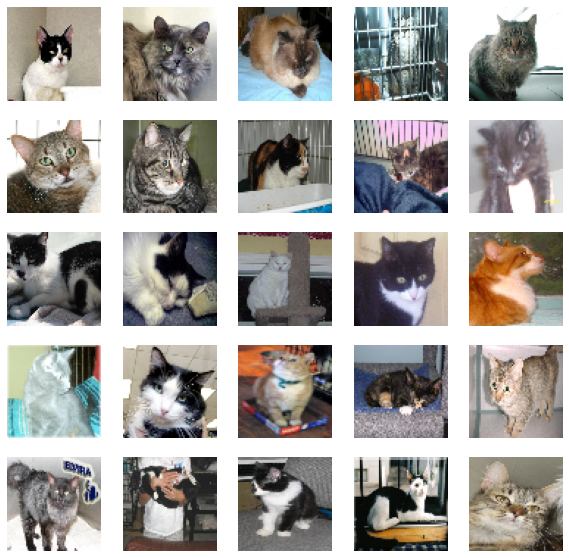

In [ ]:
# veri içindeki bazı örnekleri gösterme

import matplotlib.pyplot as plt

#figure boyutnu elle ayarlamak içib, sayılar inç türünde
fig=plt.figure(figsize=(10,10))

for i in range(25): #25 tane fotoğraf oluşturulacak
  plt.subplot(5, 5, i+1)
  # resim olarak işlenen değişken veri dizisine atılırken bir dizi olarak atıldığından 
  # burada verinin [i][0] şeklinde çağırılması yapıldı.
  
  # ayrıca opencv verileri RGB yerine BGR olarak tuttuğundan burada BGR2BGR şeklinde düzenleme yaptık.
  # çünkü imshow BGR olarak bir veri bekliyor? 
  plt.imshow(cv2.cvtColor(veri[i][0], cv2.COLOR_BGR2RGB))
  # normalde plotlar grafik çizmek için oluyor. Etrafındaki sayıları atmak için bu satır kullanılıyor.
  plt.axis('off')

plt.show()


In [ ]:
# liste şeklinde olan veriyi numpy arraylere çevirmek için

import numpy as np

# önce veriyi numpy array'ine çevir, veri sayısı * boyut * boyut * 3 şeklinde
# ardından reshape metodu çağırılıyor. Şekil istenilen durumda değilse arrayin şeklini belirlemek için
# renkli veri olduğu için 3 kanala sahip.

# -1 ->  kaç veri olduğunu önemsemeden kaç veri varsa ilk boyutta veri kadar sayı olacak anlamına geliyor
veri=np.array(veri).reshape(-1,boyut,boyut,kanal).astype("float32")

# son olarak bu işlemler için veriler normalize edilir.
# piksel değerleri [0,255] aralığında, normalize edip [-1,1] aralığına çekiyoruz. [0,1] aralığına da çekilebilirdi.
# bu network için daha elverişli hale gelmelerini sağlıyor.

veri= (veri-127.5)/127.5
# bu işlem her bir pixel için çalışır.


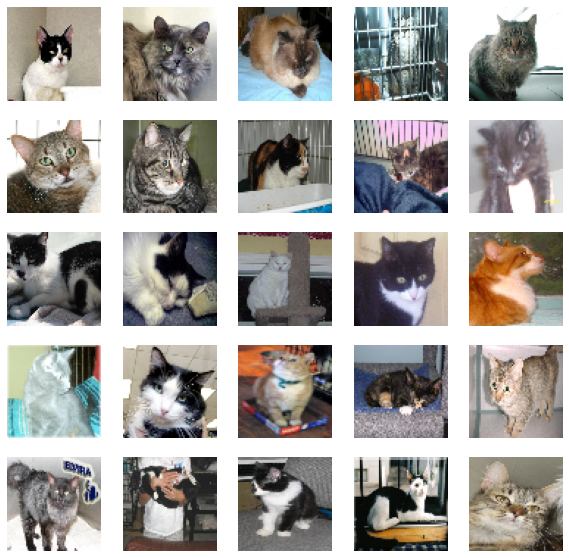

In [ ]:
# normalize edilen verileri tekrar ekrana çizmek istersek piksel değerlerini tekrar [0,255]'e çekmeliyiz

fig=plt.figure(figsize=(10,10))

for i in range(25):
  plt.subplot(5,5,i+1)

  # resim için 'uint8' türünde sayılar olmalı, o yüzden 'astype('uint8')' diyoruz.
  plt.imshow(cv2.cvtColor(((veri[i] * 127.5) + 127.5).astype('uint8'), cv2.COLOR_BGR2RGB))
  plt.axis('off')

plt.show()


Burada amaç verilen verileri yapay zekanın öğrenmesi ve ardından bu kedi resimlerine göre yeni kedi resimleri üretmek. 

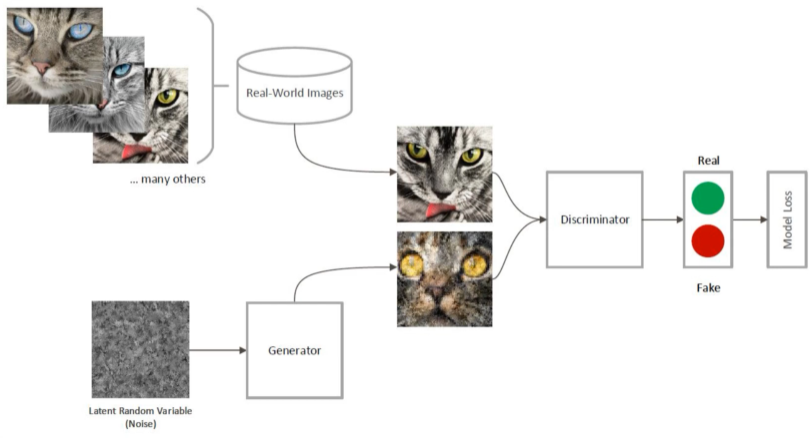

GAN yapısı
Generator- üretici
Bu network kedi resimlerini öylece çizemez bunun için bizim bu generatore bir rastgele veri vermemiz gerekiyor. yukarıda resimde görüldüğü gibi Noise bir parazit girdi olarak verilmiş.
Amaç verilen bu paraziti kedi resmine dönüştürebilmek.
bu sadece bir parazit görüntü olmak zorunda değil herhangi bir input verilebilir. birkedi resmi veya köpek resmi veya bunların çizimleri gibi inputlar olabilir.
Burada rastgele bir parazit verilmesinin sebebi farklı kedileri çizmeyi öğrenmesi. çizilen kediler arasında farklılıklar olması.

Discriminator- Ayırıcı
Bu networkün görevi oluşturulmuş resmin gerçek olup olmadığını anlamak.

Özetle sistemde generator bir resim oluşturacak ve discriminator bunun oluşturulmuş kedi resmi mi yoksa var olan kedi resmi mi olduğunu anlamaya çalışacak. Eğer Generatorün ürettiği kedi resmi discriminatorden geçerse başarılı olmuş olacak.
Eğer gerçek kedi resmi geldiğinde sahte diyen bir discriminator varsa bu durumda discriminator eğitilecek.



In [ ]:
# Eğitim ve üretim aşamaları buradan sonra başlıyor. 


import tensorflow as tf

# veri'yi tensorflow tarafından kullanılabilecek hale getiriyoruz,
# BATCH_SIZE her seferinde kaç örneği network'e göndereceğimizi
# belirliyor. GPU memory'e sığacak en büyük sayıyı kullanabiliriz,
# 1 olursa her seferinde tek örneği kullanmış oluruz, GPU'nun
# paralel işleme gücünden faydalanmamış oluruz. Ek olarak batch
# normalization kullanıyorsak onu da etkileyen bir parametre.

BATCH_SIZE= 256
# tek seferde 256 resmi GPU ya yüklenir. GPU bu işleri paralel olarak yapıyor. 
# Burada paralel işlem gücü söz konusu

veri= tf.data.Dataset.from_tensor_slices(veri).batch(BATCH_SIZE)
# bu işlem sonunda resimler bir dataset haline geldi.
# bu adımdan sonra kedi resimleri çizdirilemez.


In [ ]:
from tensorflow.python.ops.init_ops_v2 import Initializer
from tensorflow.keras import layers

# burada amaç generator oluşturmak

# generator network noise'den resim oluşturmakla görevli,
# input noise boyutu fazla değil, aşama aşama boyutu arttırmamız gerekiyor.
# zamanla boyut arttırma işlemini input istediğimiz türden resimlere dönüşecek
# şekilde yapmasını öğrenecek.

 # bir resmi oluşturmak için kaç farklı değere ihtiyacımız olduğu, elle belirlediğimiz bir sayı
NOISE_SIZE= 100  # bu sayı varyasyonu da etkiler. 

# GAN için iyi bir weight başlangıcı olarak öneriliyor
Initializer=tf.random_normal_initializer(0.,0.02)

gen=tf.keras.Sequential() 
# Dallanma olmayan yapı. 
# Bir giriş ve bir çıkıştan oluşuyor. 

gen.add(layers.Dense(4*4*512, use_bias=False, input_shape=(NOISE_SIZE,))) # 100 yani noise_size kadar rastgele sayıdan oluşan bir vektör ilk layer'a geliyor gelir.
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU()) #aktivasyon formülü. Bu formüllerin kullanım nedeni uçuk kaçık olan değerleri düzenlemek için kullanılıyor.

gen.add(layers.Reshape((4,4,512))) # burada yukarıda belirlenen boyutlu değişkeni küçük resimlere dönüştürme işlemi yapılıyor.
# 4*4 lük 512 resim

# transpoz conv yapılıyor.
gen.add(layers.Conv2DTranspose(512,(3,3), strides=(1,1),padding="same",kernel_initializer=Initializer, use_bias=False))
# 512 yeni parazit
# (3,3)lük filtreler kullanılıyor. Resim boyutları büyük olsaydı bunlar da büyütülebilirdi. 
# kernel_initializer=Initializer- filtrelerin başlangıç ağırlıkları weigth leri olur. Bunun için yukarıda belirlenen Initializer değişkeni kullanıldı.
# use_bias=False- GAN da önemli noktalardan biri budur. generator kısmında bias kullanmıyoruz.
# discriminator ile de uyumlu olmaları için orada da kullanmayacağız.
# normalde filtreyle çarpılır ve bias sayı değeri eklenirdi ancak bias burada kullanılırsa ayrıca bias da öğrenilmesi gerekecek.


# Buradaki padding filtreleri kaydırma mevzusunda kaça kaçlık matrisler gibi durumların sorun oluşturmaması için kullanılır.
# padding="same" conv transpoz layerı yani input neyse outputu da aynı boyuta getirecek şekilde matris etrafına sıfırlar getiriyor.
# strides=(1, 1)-> inputun image boyutu ne ise çıktının da boyutu o olur 

gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),padding="same",kernel_initializer=Initializer,use_bias=False))
# strides=(2,2) ise yani 1 den farklı, atlata atlata gider. 
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=Initializer, use_bias=False))
# burada strides değeri 2,2 olarak değiştirildi. 
# Burada amaç resmi büyütmek. 
# Girdi 4*4 dü şimdi çıktı 8*8 olacak. 
# Burada değer değiştirildi. Resim boyutu büyüdüğünden girdi sayısı düşürüldü. Bir şeyler arttırılırken bir şeyler küçülmezse GPU sorunu yaşanır.
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=Initializer, use_bias=False))
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(kanal, (5, 5), strides=(2, 2), padding='same', kernel_initializer=Initializer, use_bias=False, activation='tanh'))
# Son layerda farklardan biri, kaç tane olacağını kanal boyutu belirler. (RGB kanal sayısı)
# Diğer bir fark aktivasyon fonksiyonu. tanh ile Çıktının -1 ile 1 aralığına düşmesi sağlanıyor.
# Bu -1,1 aralığında olması diğer işlemlerde kolaylık sağlamasının yanı sıra
# Yapılan kullanımlarda iyi sonuç vermesinden kaynaklı

tf.Tensor(
[[ 1.8373110e+00 -2.6680210e-01 -5.1256460e-01  6.0515976e-01
   8.6252677e-01 -9.5750725e-01  9.7450763e-01 -5.5554457e-02
   1.0960585e+00 -3.8225380e-01 -9.6026920e-02 -5.0645918e-01
  -8.6598849e-01  6.1808038e-01 -2.3632841e+00  7.0820874e-01
  -8.6970019e-01 -2.6698790e+00  5.7822621e-01 -2.4609190e-01
   1.2884778e+00 -1.4897782e+00  8.0303651e-01 -4.5479140e-01
  -4.0430993e-01 -5.2399869e-04  2.1087945e+00 -1.7789747e+00
   4.1211379e-01  6.6853583e-01  2.0589724e-01 -5.0373863e-02
  -5.9902948e-01  6.5779068e-02 -2.5774679e-01  7.9815549e-01
  -8.8728684e-01 -1.1004808e+00 -3.5111759e+00  4.7293797e-01
  -1.6784868e+00  1.2491506e+00 -2.2079088e-01 -2.2092881e+00
  -2.2629733e+00  2.0005275e-01  4.4620609e-01  1.0728158e+00
  -4.4790611e-01 -1.0048841e+00]], shape=(1, 50), dtype=float32)


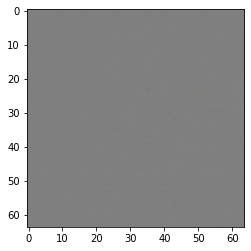

In [ ]:
# henüz eğitilmemiş gen'i test ediyoruz

noise = tf.random.normal([1, 100])
print(noise)

# gen'den output alıyoruz
test_resmi = gen(noise, training=False)

# Bu test resmini ekranda gösterirken yine normalizasyon işlemini geri alarak yapılır. 
plt.imshow(cv2.cvtColor((test_resmi[0]* 127.5 + 127.5).numpy().reshape(boyut,boyut,kanal).astype('uint8') , cv2.COLOR_BGR2RGB))

Discriminator ve Generator aslında birbirlerinin zıttı. 
Bu yüzden ikisinin boyutlarının karşılıklı benzemesi faydalıdır. 
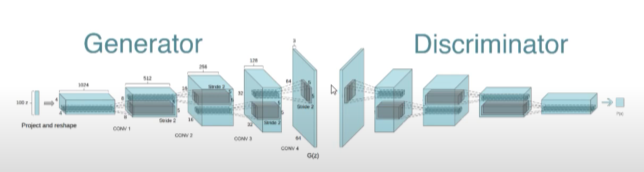

In [ ]:
# discriminator gelen resmin gerçek veya sahte olduğunu ayırt etmekle görevli

# burada amaç discriminator oluşturmak

dis = tf.keras.Sequential()

dis.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=[boyut, boyut, kanal], kernel_initializer=Initializer, use_bias=False))
# input burada noise değil bir resim boyut*boyut şeklinde 3 kanallı 
# generator ile benzer olmaları için kernel_initializer= Initializer ve bias yok
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))
# Dropout Layerlar
# discriminator kısmında bulunan bir risk var 
# Ör generatorler belli kısımlarda belli pixeller üretmeye çok meyilliyse ve bu da discriminatorü yanıltmaya neden oluyorsa
# belli pixellerde renk olarak yanlışlıklar varken discriminator bu renklere göre doğru ya da yanlış ayrımı yapıyorsa 
# rastgele şansa olarak (yukarıda 0.2 yani %20 olarak) Bu layerdan alınan pixellerin bazıları direkt atılır. 
# Böylece bu pixellere bakmadan discriminator eğitilmeye çalışılır.

# conv transpoz yerine burada direkt conv yapılır. 
dis.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=Initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=Initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer=Initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Flatten()) 
# flatten ile amaç burada bütün layerlar çarpılıp işleme geçirildikten sonra ortaya çıkarılan flatten ile tek bir vektör olarak, sayılar resim hakkında bilgi verir.
# Flatten sonrasında da Dense yada başka layerlar eklenebiliyor ancak şuan discriminator fazla güçlenmemesi ve generatore benzemesi için bu adımlar atlandı

dis.add(layers.Dense(1)) 
# son layer'da tek bir output veriyoruz,
# input resim gerçek mi yoksa sahte mi diye belirten bir sayı

In [ ]:
# henüz eğitilmeden test_resmi için ne diyor diye bakmak için
print (dis(test_resmi))
# burada çıktılarda ne kadar pozitifse o kadar gerçek ne kadar negatifse o kadar sahte olarak değer döner

tf.Tensor([[0.00032586]], shape=(1, 1), dtype=float32)


In [ ]:
# network'ü eğitmek için hangi kombinasyonların iyi/kötü olduğunu
# belirtecek sayısal bir değere ihtiyacımız var.
# loss (kayıp) fonksiyonları bunu sağlıyor.
# kısaca true label (olması gereken değerler) ve predicted label (network'ün mevcut tahminleri)
# arasındaki farkın hesaplanma yöntemi.

# Keras'daki yardımcı loss fonksiyonları: https://www.tensorflow.org/api_docs/python/tf/keras/losses


# BinaryCrossentropy: ikisi arasındaki farkları alıyor.
# sonuç iki class'dan birine ait olabilir (binary),
# iki olasılık arasındaki farkı hesaplar (true ve predicted)
# "from_logits=True" diyerek işlemi olasılık [0,1] değerleri üzerinden değil de
# bunların logaritması üzerinden yapacağımızı söylüyoruz.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# cross_entropy dediğimiz şey bize bir fonksiyon veriyor. Bu fonksiyon 2 vektör arasındaki farkları hesaplamamızı sağlıyor.
# Çünkü resimlere teker teker bakmıyoruz. Çoğul olrak yani bir batch geldi, bu batch dekileri karşılaştırıyoruz

# discriminator için olan loss fonksiyonu, train ederken kullanılacak
# input olarak gerçek resimler (real) ve generator'ün oluşturduğu
# sahte resimler (fake) veriliyor.


# Discriminator için olan loss fonksiyonu, train ederken kullanılacak input olarak gerçek resimler(real)
# ve generator'ün oluşturduğu sahte resimler (fake) veriliyor.
# Discriminatorun loss u için bir fonksiyon yazıyoruz. Discriminatorun gerçekleri sahtelerden ayırt eden loss unu yazacağız.
# Parametre olarak önce geröek kedilerimizi sonra da generatordan üretttiğimiz sahte kedilerimizi vereceğiz.
def dis_loss(real_output, fake_output):
    # gerçek olanlar için output 1 olmalıydı
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      # Bu nedenle burada tensorflowda birler oluştur diyoruz. real_output da kaç tane şey varsa batch_size ımızla ilgili onlar kadar 1 oluştur ve 
      # bu tf.ones_like(real_output) ve real_output arasındaki farka bak. Yani real_output daki bizi network ne demiş bu gerçekler için 1 demişler mi
      # burada da (tf.ones_like(real_output)) hepsi bir, bu ikisi arasındaki farklı alıyor olacağız.
    
    # sahte olanlar için de output 0 olmalıydı
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # ikisinin toplamı discriminator ın hatasını verecektir. Yani gerçeğe gerçek, sahteye sahte demesi lazım
    # yoksa loss fazla olacak bu loss miktarınca weight'ler backpropagation ile düzelecektir.

    # ikisinin toplamı discriminator'ın hatasını verecek,
    # yani gerçeğe gerçek, sahteye sahte demesi lazım, yoksa loss fazla olacak
    # bu loss miktarınca weight'ler backpropagation ile düzenlenecek.
    total_loss = real_loss + fake_loss
    return total_loss

# generator için loss daha sade, discriminator'un fake'ler için dediği 1 ise
# yani fake'e real dediyse, generator için iyi.
# discriminator fake'e fake diyorsa loss fazla olacak.

# Generator için loss daha sade, Discriminator un fake ler için dediği 1 ise yani fake e real dediyse, 
# generator için iyi. Discriminator fake e fake diyorsa loss fazla olacak.
# Generatorun yapmaya çalıştığı tek şey oluşturduğu resmi discriminator a yutturmak.
def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# optimizer loss'a göre weight'leri hangi yönde ayarlamamız gerektiğini
# bulurken kullanılıyordu. çeşitli yöntemler var, şu an için CNN'lerde
# "adam" iyi bir başlangıç sunuyor, parametre olarak verdiğimiz learning rate
# tek turda weight'lerin ne kadar oranda değişebileceğini belirtiyor.

# OPTIMIZER loss'a göre weigthleri hangi yönde ayarlamamız gerektiğini bulurken kullanılıyordu.
# Çeşitli yöntemler var, şu an için CNN'lerde "adam" iyi bir başlangıç sunuyor. 
# Parametre olarak verdiğimiz learning_rate tek turda weight'lerin ne kadar oranda değişebileceğini belirtiyor.

# iki network de farklı olduğundan iki optimizer gerekli.

gen_opt = tf.keras.optimizers.Adam(1e-4) # GAN için 10^-4 tavsiye edilen bir değerdir.
dis_opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# tek bir eğitim aşamasında yapacaklarımız
# "@tf.function" şeklinde belirmemiz bu kısmın tensorflow'da çalışacak şekilde compile edilmesini sağlıyor
@tf.function
def train_step(images):
    # BATCH_SIZE kadar noise vektörü oluştur, bu noise resmi oluşturmak için kullanılacak

    # BATCH_SIZE kadar yani 256 tane resmin her birine karşılık gelen noise-gürültü oluşturuyoruz.
    # Neden her biri için? Çünkü tek bir parazit ya da sabit sayı olursa hep aynı kediyi çizeriz.
    # Hep aynı inputdan kedi çıkarmaya çalışırız. FArklı farklı inputlardan kedi çıkarmak için her bir
    # gerçek resim için BATCH_SIZE kadar ve NOISE_SIZE kadar yani 100 tane parazit oluşturuyoruz. 
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])

    # bu kısımda yaptığımız işlemler "with tf.GradientTape()" dediğimiz için
    # takip edilecek ve türevi alınabilir halde tutulacak
    # generator ve discriminator için iki ayrı GradientTape'e ihtiyacımız var

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

       # Generator da eğitim yapmak istediğimizi belirtiyoruz. Bu yüzden training bu sefer True
       # Yukarıda hiç eğitmediğimiz haline de bir noise verip çıktı almıştık. Hiç bir şey görünmüyordu, belli değildi.

        # bu batch için noise'den image yap
        generated_images = gen(noise, training=True)

        # discriminator a gerçek resimleri verip, discriminatordan gerçek resimler ile ilgili karar alıyoruz.
        # bunlar birer resim degil. Bach bach gittiğimiz için 256 tane resmi GPU ya birden verip hepsi için sonucu aynı anda alıyor şeklinde düşünebiliriz.
        # real'i discriminator'dan geçir
        real_output = dis(images, training=True)

        # fake'i discriminator'dan geçir
        fake_output = dis(generated_images, training=True)

        # önceden yazdığımız fonksiyonlarla loss hesapla
        gen_loss_val = gen_loss(fake_output)
        dis_loss_val = dis_loss(real_output, fake_output)

#TRAİN KISMI
    # generator ve discriminator'un eğitilebilen değişkenleri için türevleri hesapla
    grad_gen = gen_tape.gradient(gen_loss_val, gen.trainable_variables)
    grad_dis = dis_tape.gradient(dis_loss_val, dis.trainable_variables)

    # ve türevleri bu değişkenlere uygula
    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    dis_opt.apply_gradients(zip(grad_dis, dis.trainable_variables))

**Gradyanları Hesaplama**

Otomatik olarak farklılaşmak için TensorFlow'un ileri geçiş sırasında hangi işlemlerin hangi sırayla gerçekleştiğini hatırlaması gerekir. Ardından, geriye doğru geçiş sırasında TensorFlow, gradyanları hesaplamak için bu işlem listesini ters sırayla geçer.

**Gradient Tapes** - Gradiyan Bantları

Tensorflow tf.GradientTape, belirli bir bağlamda yürütülen işlemleri kaydederek belirli girdilerin gradyanını hesaplamak için otomatik farklılaşmayı takip etmektedir.

Gradyan bandı kendi özelleştirilmiş optimizerımızı yapmak için ve otomatik farklılaşma için kullanabiliriz.

**Örnek:**

x = 2

y = 3x^4

dy/dx = 4*3x^3     

dy/dx = 4\*3*2^3 = 96



```
import tensorflow as tf
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y = 3 * x ** 4
  dy_dx = tape.gradient(y,x)
print(dy_dx)

```
**Çıktı:**  tf.Tensor(96.0, shape=(), dtype=float32)



In [ ]:
from IPython import display # çıktıyı temizlemek için kullanacağız

EPOCHS = 5000 # eğitim sırasında tüm veri üzerinden kaç kez geçeceğimiz

# her epoch sonunda generator'ün halini kontrol ederken bu seed'i kullanacağız
seed = tf.random.normal([25, NOISE_SIZE]) # 25 tane farklı noise, 25 farklı image gösterebilmek için

# her epoch'da
for epoch in range(EPOCHS):
    
    # her batch için
    for image_batch in veri:
        # bir tur eğitim fonksiyonunu çağırır
        train_step(image_batch)

    # bir epoch sonunda generator'ün ne durumda olduğunu kontrol etmek istiyoruz
    # aynı seed'i verip oluşturulan resimleri alıyoruz
    predictions = gen(seed, training=False)

# Ekranda göstermek için 
    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(cv2.cvtColor((predictions[i]* 127.5 + 127.5).numpy().reshape(boyut,boyut,kanal).astype('uint8') , cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.show()

  # Eldeki verileri karıştırmak
  # Bazen bazı batchler bir araya geldikleri zaman batch normalizasyonunu bozuyor. Bunun için eldeki veriler karıştırılır.
  # ÖR arka arkaya gelen kedi resimlerinin hepsi bozuk bu sonucu bozacak normalizasyonu bozacaktır. 
  # böyle bir durum yaşamamak için batchleri karıştırma işlemi yapılıyor.
    veri.shuffle(10000)

    # eski çizimi temizle
    display.clear_output(wait=True)

KeyboardInterrupt: ignored

In [ ]:
# Modeli kaydetmek


In [ ]:
# Optimiter değiştirmek
gen_opt.learning_rate.assign(2e-5)
dis_opt.learning_rate.assign(2e-5)